# Data Processing

## Table of contents

1. [Introduction](#Introduction)

2. [Tables Preprocessing](#Tables-Preprocessing)

    2.1 [Account Relation Data Preprocessing](#Account-Relation-Data-Preprocessing)

    2.2 [Client Relation Data Preprocessing](#Client-Relation-Data-Preprocessing)

    2.3 [Card Relation Data Preprocessing](#Card-Relation-Data-Preprocessing)

    2.4 [Loan Relation Data Preprocessing](#Loan-Relation-Data-Preprocessing)

    2.5 [Transaction Relation Data Preprocessing](#Transaction-Relation-Data-Preprocessing)

    2.6 [District Relation Data Preprocessing](#District-Relation-Data-Preprocessing)

3. [Merging Datasets](#Merging-Datasets)

4. [Handling Outliers](#Handling-Outliers)

    4.1 [Z-Score](#Z-Score)

    4.2 [Box Plots](#Box-Plots)

5. [Feature Selection](#Feature-Selection)

    5.1 [SelectKBest](#SelectKBest)

    5.2 [SelectFromModel with RandomForestClassifier](#SelectFromModel-with-RandomForestClassifier)

6. [Export Preprocessed Data](#Export-Preprocessed-Data)


## Introduction
In this notebook, we process our dataset data. For each table, we made various operations, for example, drop unimportant columns, transform columns to more convenient ones, deal with missing values and outliers, extract new columns from the aggregation of the existing ones, etc. In the end, we merge all the tables into a final one, so that it's easier to use the data in the application of the machine learning models.

## Tables Preprocessing
In this section, we preprocess the data of each relation of our dataset.

### Account Relation Data Preprocessing
For the account relation, we transform the `date` column to a new one called `year_since_acc_open`. The new column corresponds to the number of years since the account was open. Because the dataset is a little bit old, we are not computing the number of years in relation to today. Instead, we are considering the year 2003, to be consistent with the date we choose in the client relation. To see why who choose the year 2003, please check the client relation preprocessing section.

In [1]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

def transform_df_with_date(df, columnName, newColumnName):
  df[columnName] = df[columnName].apply(normalize_date)
  df.rename(columns={columnName: newColumnName}, inplace = True)

def normalize_date(accountDate):
  original_date = datetime.strptime(str(accountDate), '%y%m%d')
  date_in_2003 = datetime.strptime("01-01-2003", "%m-%d-%Y")
  return relativedelta(date_in_2003, original_date).years

account_data = pd.read_csv("./files/account.csv", sep=";", index_col=0)
transform_df_with_date(account_data, "date", "years_since_acc_open")
account_data.to_csv("./preprocessed/account.csv")

### Client Relation Data Preprocessing
For the client relation, we make some operations in the `birth_number` column. This column contains the birthday and the sex of the client, which is a number that is in the form YYMMDD for men and in the form YYMM+50DD for women, where YYMMDD is the date of birth. To make it easier to see the values of the sex and birthday, we transform this column to two new ones: `gender` and `age`. Note that we are using age instead of the original birth date, because it's easier to use integer numbers than dates, both in the data understanding and in the model application phases. As in the account relation data processing phase, we are considering the date 2003 instead of today. This is the year from which the minimum age of the clients is 18, the legal age from when a person can ask for a loan.

Text(0.5, 1.0, 'Distribution of Client Ages')

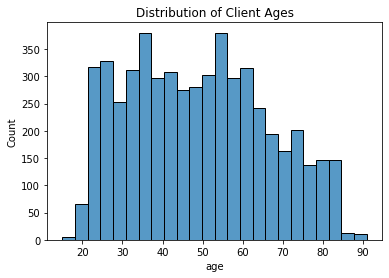

In [2]:
import re
import seaborn as sb

client_data = pd.read_csv("./files/client.csv", sep=";", index_col=0)

clientGenders = []
clientAge = []

def normalize_birthNumber(clientBirthNumber):
  dateSearch = re.search('(\d{2})(\d{2})(\d{2})', str(clientBirthNumber))
  years = int(dateSearch.group(1))
  months = int(dateSearch.group(2))
  days = int(dateSearch.group(3))
  
  gender = "M"
  if months > 12:
    gender = "F"
    months = months - 50

  original_date = datetime.strptime(f"19{years}-{months}-{days}", '%Y-%m-%d')
  date_in_2003 = datetime.strptime("01-01-2003", "%m-%d-%Y")
  age = relativedelta(date_in_2003, original_date).years

  clientGenders.append(gender)
  clientAge.append(age)


client_data.birth_number = client_data.birth_number.apply(normalize_birthNumber)
client_data['gender'] = clientGenders
client_data['age'] = clientAge

sb.histplot(data=client_data, x="age",).set_title("Distribution of Client Ages")

As we can see in the plot above, the age distribution of the clients can vary, depending on the age group. In order to divide the ages of the clients into age groups, we implemented a age equal-frequency discretization, so that we have age groups with approximately the same number of samples, with the aid of the `KBinsDiscretizer` method from sklearn. We end up with a new column `age_group`, which can have 5 different values. Because we don't need the `birth_number` and `age` columns anymore, we drop both of them in the end.

After Discretization: 



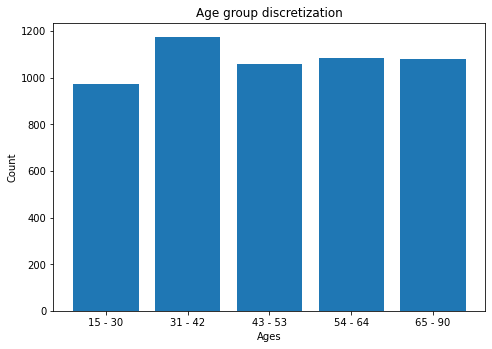

In [3]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# Equal-Frequency Discretization
number_bins = 5

client_age_data = client_data['age'].values.reshape(-1,1)
discretizer = KBinsDiscretizer(n_bins=number_bins, encode='ordinal', strategy='quantile')
client_data['age_group'] = discretizer.fit_transform(client_age_data)

# Discretization meaning
bins = []
values = client_data['age_group'].tolist().count(0.0), client_data['age_group'].tolist().count(1.0), \
  client_data['age_group'].tolist().count(2.0), client_data['age_group'].tolist().count(3.0), \
  client_data['age_group'].tolist().count(4.0)

print("After Discretization: \n")
for i in range(0, 5):
  limits = f"{discretizer.bin_edges_[0][i]:.0f} - {(discretizer.bin_edges_[0][i + 1] - 1):.0f}"
  bins.append(limits)
  
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(bins, values)
plt.title('Age group discretization')
plt.xlabel('Ages')
plt.ylabel('Count')
plt.show()

client_data.drop(columns = ['birth_number', 'age'], inplace = True)
client_data.to_csv("./preprocessed/client.csv")

### Card Relation Data Preprocessing
In this relation, which contains both train and test tables, we transform the `issued` column, which is a date. We end up with a new column, `years_since_issued`, that represents the number of years since the card was issued, in relation to 2003, because of the aforementioned reasons.

In [4]:
card_test_data = pd.read_csv("./files/card_test.csv", sep=";", index_col=0)
card_train_data = pd.read_csv("./files/card_train.csv", sep=";", index_col=0)

transform_df_with_date(card_test_data, "issued", "years_since_issued")
transform_df_with_date(card_train_data, "issued", "years_since_issued")

card_test_data.to_csv("./preprocessed/card_test.csv")
card_train_data.to_csv("./preprocessed/card_train.csv")   

### Loan Relation Data Preprocessing
In this relation, which also contains both train and test tables, we transform the `date` column in a similar way to what we did in the other relations.

In [5]:
loan_test_data = pd.read_csv("./files/loan_test.csv", sep=";")
loan_train_data = pd.read_csv("./files/loan_train.csv", sep=";")

transform_df_with_date(loan_train_data, "date", "years_since_loan")
transform_df_with_date(loan_test_data, "date", "years_since_loan")

loan_test_data.to_csv("./preprocessed/loan_test_data.csv")
loan_train_data.to_csv("./preprocessed/loan_train_data.csv")

### Transaction Relation Data Preprocessing
In this relation, we are doing multiple operations. We start by getting the interquartile range (IQR) for each account, by computing the difference between the first and the third quartile. We create a new column `itr_balance_per_account` which contains that information. Then, we create new columns with the values of statistics of the existing ones, for example for the balance and for the different types of operations. Furthermore, we made the values of the withdrawal negative, to better represent the information. For the operations, we also added its ratios. A total of 63 new columns were created in this phase.

In [6]:
import numpy as np

def iqr_trans_data(df):
  test_df = df.sort_values(by=['account_id'])
  test_df = test_df.groupby(['account_id']).first()
  
  # Get different account_ids
  account_ids = test_df.index
  iqr_per_account = []

  # Compute Standard Deviation for every account_id
  for account_id in account_ids:
    q3, q1 = np.percentile(df.loc[lambda df: df['account_id'] == account_id]['balance'], [75 ,25])
    iqr_per_account.append(q3 - q1)

  return iqr_per_account


def preprocess_transaction(df):
  iqr_per_account = iqr_trans_data(df)

  # Types of withdrawal in cash = withdrawal
  df.loc[df["type"] == "withdrawal in cash", "type"] = "withdrawal"

  # Withdrawals have negative balance
  df.loc[df["type"] == "withdrawal", "amount"] *= -1

  # Null Operation values are equivalent to Interest Credited as in k_symbol
  df["operation"].fillna('IC', inplace=True)

  # Renaming operations
  df.loc[df["operation"] == "collection from another bank", "operation"] = "CAB"
  df.loc[df["operation"] == "remittance to another bank", "operation"] = "RAB"
  df.loc[df["operation"] == "withdrawal in cash", "operation"] = "WC"
  df.loc[df["operation"] == "credit card withdrawal", "operation"] = "CCW"
  df.loc[df["operation"] == "credit in cash", "operation"] = "CC"
  
  first = lambda df: df.iloc[0]
  last = lambda df: df.iloc[-1]

  # Handling Transaction balances
  agg_balance = df.sort_values(by=['account_id', 'date'], ascending=[True, False]) \
                    .groupby(['account_id']) \
                    .agg({
                        'balance': ['mean', 'max', 'min', 'std', first, last],
                        'date': first,
                        'amount': first
                    }) \
                    .reset_index()
  
  agg_balance.columns = ['account_id', 'balance_mean', 'balance_max', 'balance_min', 'balance_std',
                          'last_balance', 'first_balance', 'last_trans_date', 'last_trans_amount']
  
  # Feature reached_negative_balance
  agg_balance['reached_negative_balance'] = agg_balance['balance_min']
  agg_balance.loc[agg_balance["balance_min"] >= 0, "reached_negative_balance"] = 1
  agg_balance.loc[agg_balance["balance_min"] < 0, "reached_negative_balance"] = -1

  # Handlign credits and withdrawals
  agg_types = df.sort_values(by=['account_id'], ascending=[True]) \
                            .groupby(['account_id', 'type']) \
                            .agg({
                                'amount': ['mean', 'count', 'max', 'min', 'std'],
                            }) \
                            .reset_index()

  agg_types.columns = ['account_id', 'type', 'type_mean', 'type_count', 'type_max', 'type_min', 'type_std']

  agg_credits = agg_types[agg_types['type'] == 'credit']
  agg_credits.columns = ['account_id', 'type', 'credit_mean', 'credit_count', 'credit_max', 'credit_min', 'credit_std']
  agg_credits.drop(['type'], axis=1)
  
  agg_withdrawals = agg_types[agg_types['type'] == 'withdrawal']
  agg_withdrawals.columns = ['account_id', 'type', 'withdrawal_mean', 'withdrawal_count', 'withdrawal_max', 'withdrawal_min', 'withdrawal_std']
  agg_withdrawals.drop(['type'], axis=1)

  # Merging aggregated datasets - balance, credits and withdrawals
  agg_df = agg_balance.merge(agg_credits, on='account_id', how='left').merge(agg_withdrawals, on='account_id', how='left')

  # Clean missing values
  agg_df.fillna(0, inplace=True)

  # Cleaning nulls and performing aggregation on table containing operations
  operations = df.groupby(['account_id', 'operation']) \
                          .agg({
                              'amount': ['count', 'mean', 'sum', 'max', 'std', 'min'],
                          }) \
                          .reset_index()

  operations.columns = ['account_id', 'operation', 'amount_count', 'amount_mean', 'amount_sum', 'amount_max', 'amount_std', 'amount_min']
  
  # IC
  ic = operations[operations['operation'] == 'IC']
  ic.columns = ['account_id', 'operation', 'IC', 'IC_mean', 'IC_sum', 'IC_max', 'IC_std', 'IC_min']
  ic = ic.drop(['operation'], axis=1)

  # CC
  cc = operations[operations['operation'] == 'CC']
  cc.columns = ['account_id', 'operation', 'CC', 'CC_mean', 'CC_sum', 'CC_max', 'CC_std', 'CC_min']
  cc = cc.drop(['operation'], axis=1)
  
  # CAB
  cab = operations[operations['operation'] == 'CAB']
  cab.columns = ['account_id', 'operation', 'CAB', 'CAB_mean', 'CAB_sum', 'CAB_max', 'CAB_std', 'CAB_min']
  cab =cab.drop(['operation'], axis=1)
  
  # WC
  wc = operations[operations['operation'] == 'WC']
  wc.columns = ['account_id', 'operation', 'WC', 'WC_mean', 'WC_sum', 'WC_max', 'WC_std', 'WC_min']
  wc = wc.drop(['operation'], axis=1)
  
  # RAB
  rab = operations[operations['operation'] == 'RAB']
  rab.columns = ['account_id', 'operation', 'RAB', 'RAB_mean', 'RAB_sum', 'RAB_max', 'RAB_std', 'RAB_min']
  rab = rab.drop(['operation'], axis=1)
  
  # CCW
  ccw = operations[operations['operation'] == 'CCW']
  ccw.columns = ['account_id', 'operation', 'CCW', 'CCW_mean', 'CCW_sum', 'CCW_max', 'CCW_std', 'CCW_min']
  ccw = ccw.drop(['operation'], axis=1)
  
  # Joining all the operations
  operations_df = cc.merge(cab, on='account_id', how='left') \
                    .merge(ic, on='account_id', how='left') \
                    .merge(wc, on='account_id', how='left') \
                    .merge(rab, on='account_id', how='left') \
                    .merge(ccw, on='account_id', how='left')
  
  # Clean missing values
  operations_df.fillna(0, inplace=True)

  # Mergind balance, types & operations
  new_df = agg_df.merge(operations_df, on='account_id', how='left')

  # Preprocess date to years since transaction
  transform_df_with_date(new_df, "last_trans_date", "years_since_transaction")

  # Adding extra columns
  new_df['total_ops'] = new_df['CC'] + new_df['CAB'] + new_df['WC'] + new_df['RAB'] + new_df['CCW'] + new_df['IC']
  new_df['credit_ratio'] = new_df['credit_count'] / new_df['total_ops']
  new_df['withdrawal_ratio'] = new_df['withdrawal_count'] / new_df['total_ops']
  new_df['mean_trans_profit'] = new_df['credit_mean'] + new_df['withdrawal_mean']
  new_df['itr_balance_per_account'] = iqr_per_account
  new_df['balance_range'] = new_df['balance_max'] - new_df['balance_min']
  new_df['last_first_balance_ratio'] = new_df['last_balance'] / new_df['first_balance']
  new_df['last_max_balance_ratio'] = new_df['last_balance'] / new_df['balance_max']

  # OPs as ratios
  new_df['ratio_IC'] = new_df['IC'] / new_df['total_ops']
  new_df['ratio_CC'] = new_df['CC'] / new_df['total_ops']
  new_df['ratio_CAB'] = new_df['CAB'] / new_df['total_ops']
  new_df['ratio_WC'] = new_df['WC'] / new_df['total_ops']
  new_df['ratio_RAB'] = new_df['RAB'] / new_df['total_ops']
  new_df['ratio_CCW'] = new_df['CCW'] / new_df['total_ops']

  return new_df

trans_test_data = pd.read_csv("./files/trans_test.csv", sep=";", index_col=0, low_memory=False)
trans_train_data = pd.read_csv("./files/trans_train.csv", sep=";", index_col=0, low_memory=False)

trans_train_data = preprocess_transaction(trans_train_data)
trans_test_data = preprocess_transaction(trans_test_data)

trans_test_data.to_csv("./preprocessed/trans_test_data.csv")  
trans_train_data.to_csv("./preprocessed/trans_train_data.csv") 

### District Relation Data Preprocessing
In this relation, the main transformations are:
- Compute the average variation of North Moravia region regarding the unemployment rate in 95' and 96' and use it to substitute the "?" in "unemployment rate '95" column
- Compute the average variation of North Moravia region regarding the number of commited crimes in 95' and 96' and use it to substitute the "?" in "no. of commited crimes '95" column
- Sum and computed average of "unemploymant rate '95" e "unemploymant rate '96" columns and create new unemployment_rate column
- Sum and computed average of "no. of commited crimes '95" e "no. of commited crimes '96" columns and create new no. of commited crimes column
- Sum "no. of municipalities with inhabitants 500-1999" with "no. of municipalities with inhabitants 2000-9999" and create "no. of municipalities with inhabitants > 2000" column
- Remove unnecessary columns

In [7]:
pd.options.mode.chained_assignment = None # remove SettingWithCopyWarning

district_data = pd.read_csv("./files/district.csv", index_col=None)

validDistrictData = district_data.loc[lambda df: (df["unemploymant rate '95 "] != "?") & (df["no. of commited crimes '95 "] != "?")] # The region where the "?" is located.

def avgVariationNMoravia(first_col, second_col):
  validDistrictData[first_col] = pd.to_numeric(validDistrictData[first_col])
  validDistrictData[second_col] = pd.to_numeric(validDistrictData[second_col])
  variationAll = np.subtract(validDistrictData[second_col], validDistrictData[first_col])

  return np.array([-y / x for x, y in zip(validDistrictData[second_col], variationAll)]).mean()

avgUnemploymentVariation = avgVariationNMoravia("unemploymant rate '95 ", "unemploymant rate '96 ")
avgCommitedCrimesVariation = avgVariationNMoravia("no. of commited crimes '95 ", "no. of commited crimes '96 ")

# Calculate "?" value in columns "unemploymant rate '95" and "no. of commited crimes '95"
knownUnemployment96 = district_data.loc[lambda df: df["unemploymant rate '95 "] == "?"]["unemploymant rate '96 "].item()
newUnemployment95 = (knownUnemployment96 + (knownUnemployment96 * avgUnemploymentVariation))
knownCommitedCrime96 = district_data.loc[lambda df: df["no. of commited crimes '95 "] == "?"]["no. of commited crimes '96 "].item()
newCommitedCrime95 = int(knownCommitedCrime96 + (knownCommitedCrime96 * avgCommitedCrimesVariation))

def replaceMissingVal(district_data, col, newValue):
  district_data[col].replace({"?": newValue}, inplace=True)

  return district_data

district_data = replaceMissingVal(district_data, "unemploymant rate '95 ", newUnemployment95)
district_data = replaceMissingVal(district_data, "no. of commited crimes '95 ", newCommitedCrime95)

# Convertion of columns to int/float:
district_data['unemploymant rate \'95 '] = district_data['unemploymant rate \'95 '].astype(float)
district_data['unemploymant rate \'96 '] = district_data['unemploymant rate \'96 '].astype(float)
district_data['no. of commited crimes \'95 '] = pd.to_numeric(district_data['no. of commited crimes \'95 '])
district_data['no. of commited crimes \'96 '] = pd.to_numeric(district_data['no. of commited crimes \'96 '])
district_data['ratio of urban inhabitants '] = district_data['ratio of urban inhabitants '].astype(float)
district_data['no. of enterpreneurs per 1000 inhabitants '] = pd.to_numeric(district_data['no. of enterpreneurs per 1000 inhabitants '])

# Creating new features:
district_data['ratio entrepeneurs'] = district_data['no. of enterpreneurs per 1000 inhabitants '] / 1000
district_data['criminality_growth'] = (district_data['no. of commited crimes \'96 '] - district_data['no. of commited crimes \'95 ']) /\
                                       district_data['no. of inhabitants']
district_data['unemploymant_growth'] = district_data['unemploymant rate \'96 '] - district_data['unemploymant rate \'95 ']
    
district_data["no. of municipalities with inhabitants 500-1999"] = pd.to_numeric(district_data["no. of municipalities with inhabitants 500-1999"])
district_data["no. of municipalities with inhabitants 2000-9999 "] = pd.to_numeric(district_data["no. of municipalities with inhabitants 2000-9999 "])
district_data["no. of municipalities with inhabitants > 2000"] = np.add(district_data["no. of municipalities with inhabitants 500-1999"], district_data["no. of municipalities with inhabitants 2000-9999 "])

district_data.drop(columns = [
    "unemploymant rate '95 ",
    "unemploymant rate '96 ",
    "no. of municipalities with inhabitants 2000-9999 ",
    "no. of municipalities with inhabitants >10000 ",
    "no. of commited crimes '95 ",
    "no. of commited crimes '96 ",
    "name"
], inplace = True)

district_data.to_csv("./preprocessed/district.csv")

## Merging Datasets
In this section, we merge all datasets and then compute the train and test datasets.

In [8]:
# Merge train Data

merged_data_train = pd.merge(loan_train_data, trans_train_data, on="account_id")
merged_data_train = pd.merge(merged_data_train, account_data, on="account_id")

district_data.rename(columns={"code": "district_id"}, inplace=True)
merged_data_train = pd.merge(merged_data_train, district_data, how="left", on="district_id")

disp_data = pd.read_csv("./files/disp.csv", sep=";")
merged_data_train = pd.merge(merged_data_train, disp_data, on="account_id")

# Remove rows with DISPONENT clients (because only owners can ask for a loan)
merged_data_train = merged_data_train.loc[lambda df: df['type'] != 'DISPONENT']

merged_data_train = pd.merge(merged_data_train, client_data, on="client_id")

merged_data_train.drop(columns = ['account_id', 'district_id_x', 'district_id_y', 'disp_id', 'client_id', 'type', 'type_x'], inplace = True)

# -----------------------------------------------------------------------------
# Merge test Data

merged_data_test = pd.merge(loan_test_data, trans_test_data, on="account_id")
merged_data_test = pd.merge(merged_data_test, account_data, on="account_id")

district_data.rename(columns={"code": "district_id"}, inplace=True)
merged_data_test = pd.merge(merged_data_test, district_data, how="left", on="district_id")

disp_data = pd.read_csv("./files/disp.csv", sep=";")
merged_data_test = pd.merge(merged_data_test, disp_data, on="account_id")

# Remove rows with DISPONENT clients (because only owners can ask for a loan)
merged_data_test = merged_data_test.loc[lambda df: df['type'] != 'DISPONENT']

merged_data_test = pd.merge(merged_data_test, client_data, on="client_id")

merged_data_test.drop(columns = ['account_id', 'district_id_x', 'district_id_y', 'disp_id', 'client_id'], inplace = True)

# Handling Outliers
To remove the outliers, we use Z-Score, which indicates how many standard deviation away a data point is, and box plots, removing the data points that lie above or below IQR (Inter Quartile Range) * 1.5.

## Z-Score

In [9]:
from scipy import stats

def remove_outliers_with_z_score(df, to_remove=None):
    if to_remove is None:
        to_remove = ["amount", "payments", "itr_balance_per_account", \
        "average salary ", "criminality_growth", "unemploymant_growth", \
        "mean_trans_profit", "balance_range"
        ]

    z = np.abs(stats.zscore(df[to_remove]))

    df = df[(z < 3).all(axis=1)]

    return df

## Uncomment to remove outliers with z-score
#number_of_rows = merged_data_train.shape[0]
#merged_data_train = remove_outliers_with_z_score(merged_data_train)
#print(f"Removed {number_of_rows - merged_data_train.shape[0]} outliers")

## Box Plots

In [10]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(10, 9,figsize=(100,100))

def draw_box_plot(axis, i, j, df, column):
    axis[i, j].boxplot(df[column])
    axis[i, j].set_title(column)

columns = list(merged_data_train._get_numeric_data().columns)
columns_to_remove = ["loan_id"]

columns = list(filter(lambda x: x not in columns_to_remove, columns))

number_of_columns = len(columns)

i, j, column_index = 0, 0, 0

for i in range(10):
    for j in range(9):

        if (column_index >= number_of_columns):
            break

        draw_box_plot(axis, i, j, merged_data_train, columns[column_index])
        column_index += 1

plt.tight_layout()
plt.show()

As we can see in the box plots, there are some columns that contain outliers. An outlier is any data point that lies above or below 1.5 * IRQ, as we can see in the image below:
![](images/box_plot_outliers.png)

Next, we're going to implement a function to remove these data points:

In [11]:
def remove_column_outliers_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    filter = (df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 - 1.5 * IQR))

    return df.loc[filter]

## Uncomment to remove outliers with the box plot method
# rows_before = len(merged_data_train.index)
# columns = ["amount", "payments", "last_balance", "no. of inhabitants"]
# for column in columns:
#     merged_data_train = remove_column_outliers_IQR(merged_data_train, column)
# rows_after = len(merged_data_train.index)
# print(f"Removed {rows_before - rows_after} outliers")

After the data understanding phase, we discovered that there are much fewer loans that failed. For that reason, the values of the columns of the failed loans can be considered outliers. Therefore, we didn't remove the outliers of the features that will be used in the machine learning models.

## Feature Selection

For the feature selection, we used SelectKBest and SelectFromModel with RandomForestClassifier as estimator.

### SelectKBest

The SelectKBest method, from sklearn.feature_selection, uses the f_classif score function, which computes the ANOVA F-value between label/feature. The F value is a value on the F distribution. The F value is used in analysis of variance (ANOVA). This calculation determines the ratio of explained variance to unexplained variance. This gives us the features with the highest scores.

In [12]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
import math

# Remove divide warnings
np.seterr(divide='ignore', invalid='ignore')

def encode_df(df):
  columnsToEncode = list(df.select_dtypes(include=['object']))
  le = LabelEncoder()
  for feature in columnsToEncode:
      try:
          df[feature] = le.fit_transform(df[feature])
      except:
          df.drop(columns = [feature], inplace = True)
  return df

merged_data_train = encode_df(merged_data_train)

features = list(merged_data_train.columns)
features = list(filter(lambda x: x != "status", features))

X = merged_data_train[features]
Y = merged_data_train[['status']]

number_of_features = 20

# feature extraction
test = SelectKBest(score_func=f_classif, k=number_of_features)
fit = test.fit(X, Y.values.ravel())

# summarize scores
set_printoptions(precision=3)

fit.transform(X)

scores = list(fit.scores_)

features_scores = {}

for i in range(len(scores)):
  features_scores[features[i]] = scores[i] if not math.isnan(scores[i]) else 0
  
best_features = []

# Get number_of_features best features
selected = sorted(features_scores, key=features_scores.get, reverse=True)[:number_of_features]

print("Selected features:")
print(selected)

Selected features:
['reached_negative_balance', 'RAB_mean', 'RAB_min', 'RAB_max', 'ratio_RAB', 'balance_min', 'IC_mean', 'withdrawal_ratio', 'credit_ratio', 'ratio_CC', 'CC_std', 'RAB_sum', 'balance_mean', 'mean_trans_profit', 'RAB', 'CC_max', 'IC_min', 'payments', 'CAB_min', 'CAB_mean']


### SelectFromModel with RandomForestClassifier
Random forests consist of 4 –12 hundred decision trees, each of them built over a random extraction of the observations from the dataset and a random extraction of the features. Not every tree sees all the features or all the observations, and this guarantees that the trees are de-correlated and therefore less prone to over-fitting. Each tree is also a sequence of yes-no questions based on a single or combination of features. At each node (this is at each question), the three divides the dataset into 2 buckets, each of them hosting observations that are more similar among themselves and different from the ones in the other bucket. Therefore, the importance of each feature is derived from how "pure" each of the buckets is.

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

selected_features = []

def select_features_RF(origin_df):
    df = origin_df.drop(['loan_id'], axis=1)
    y = origin_df["status"]
    features = list(df.columns)
    X = df[features]
    cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

    for train_index, _ in cv.split(X, y):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]

        sel = SelectFromModel(
            RandomForestClassifier(
                n_estimators = 250,
                class_weight = 'balanced_subsample',
                max_features="sqrt",
                criterion = 'entropy',
                random_state=0
                )
            )
        sel.fit(X_train, y_train)

        # Save selected columns
        for col in X_train.columns[(sel.get_support())]:
            if col not in selected_features:
                selected_features.append(col)


    print("Selected features:")
    print(selected_features)

select_features_RF(merged_data_train)

Selected features:
['amount', 'payments', 'status', 'balance_mean', 'balance_min', 'last_balance', 'CC_max', 'IC_min', 'RAB', 'RAB_mean', 'RAB_sum', 'RAB_max', 'RAB_min', 'mean_trans_profit', 'last_first_balance_ratio', 'last_max_balance_ratio', 'ratio_RAB', 'last_trans_amount', 'reached_negative_balance', 'withdrawal_max', 'IC_mean', 'credit_ratio', 'withdrawal_ratio', 'balance_max', 'IC_max', 'ratio_IC', 'ratio_CC', 'CC_std', 'CAB_mean', 'WC_max']


# Export Preprocessed Data

In [14]:
merged_data_train.to_csv("./preprocessed/mergedTrainData.csv", index=None)
merged_data_test.to_csv("./preprocessed/mergedTestData.csv", index=None)